
FOLD 1/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5211, Train Acc 0.4330, Val Loss 0.4681, Val Acc 0.5420
Epoch 2: Train Loss 0.4322, Train Acc 0.5358, Val Loss 0.3471, Val Acc 0.6361
Epoch 3: Train Loss 0.3910, Train Acc 0.5956, Val Loss 0.3227, Val Acc 0.6934
Epoch 4: Train Loss 0.3603, Train Acc 0.6344, Val Loss 0.3041, Val Acc 0.6959
Epoch 5: Train Loss 0.3474, Train Acc 0.6430, Val Loss 0.2946, Val Acc 0.7417
Epoch 6: Train Loss 0.3262, Train Acc 0.6755, Val Loss 0.2725, Val Acc 0.7557
Epoch 7: Train Loss 0.3072, Train Acc 0.6942, Val Loss 0.2838, Val Acc 0.7354
Epoch 8: Train Loss 0.3050, Train Acc 0.6802, Val Loss 0.2764, Val Acc 0.7354
Epoch 9: Train Loss 0.3099, Train Acc 0.6847, Val Loss 0.2269, Val Acc 0.7824
Epoch 10: Train Loss 0.3083, Train Acc 0.6841, Val Loss 0.2250, Val Acc 0.8015
Epoch 11: Train Loss 0.2998, Train Acc 0.6914, Val Loss 0.2182, Val Acc 0.7990
Epoch 12: Train Loss 0.2805, Train Acc 0.7156, Val Loss 0.2384, Val Acc 0.7913
Epoch 13: Train Loss 0.2781, Train Acc 0.7171, Val Loss 0.250

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5122, Train Acc 0.4486, Val Loss 0.3940, Val Acc 0.6043
Epoch 2: Train Loss 0.4212, Train Acc 0.5552, Val Loss 0.3496, Val Acc 0.6336
Epoch 3: Train Loss 0.3795, Train Acc 0.6115, Val Loss 0.3057, Val Acc 0.6807
Epoch 4: Train Loss 0.3746, Train Acc 0.6198, Val Loss 0.3169, Val Acc 0.6705
Epoch 5: Train Loss 0.3359, Train Acc 0.6564, Val Loss 0.2887, Val Acc 0.6972
Epoch 6: Train Loss 0.3400, Train Acc 0.6487, Val Loss 0.2829, Val Acc 0.7341
Epoch 7: Train Loss 0.3267, Train Acc 0.6688, Val Loss 0.2625, Val Acc 0.7341
Epoch 8: Train Loss 0.3159, Train Acc 0.6901, Val Loss 0.2520, Val Acc 0.7595
Epoch 9: Train Loss 0.3054, Train Acc 0.7000, Val Loss 0.2582, Val Acc 0.7392
Epoch 10: Train Loss 0.2865, Train Acc 0.7086, Val Loss 0.2395, Val Acc 0.7710
Epoch 11: Train Loss 0.2983, Train Acc 0.6892, Val Loss 0.2082, Val Acc 0.7964
Epoch 12: Train Loss 0.2844, Train Acc 0.7079, Val Loss 0.2248, Val Acc 0.7621
Epoch 13: Train Loss 0.2887, Train Acc 0.7111, Val Loss 0.181

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5174, Train Acc 0.4400, Val Loss 0.4176, Val Acc 0.5483
Epoch 2: Train Loss 0.4288, Train Acc 0.5409, Val Loss 0.3675, Val Acc 0.6260
Epoch 3: Train Loss 0.3778, Train Acc 0.6109, Val Loss 0.3125, Val Acc 0.6807
Epoch 4: Train Loss 0.3644, Train Acc 0.6172, Val Loss 0.2978, Val Acc 0.7048
Epoch 5: Train Loss 0.3427, Train Acc 0.6481, Val Loss 0.2879, Val Acc 0.7366
Epoch 6: Train Loss 0.3314, Train Acc 0.6545, Val Loss 0.2952, Val Acc 0.7099
Epoch 7: Train Loss 0.3107, Train Acc 0.6688, Val Loss 0.2559, Val Acc 0.7532
Epoch 8: Train Loss 0.3036, Train Acc 0.6911, Val Loss 0.2828, Val Acc 0.7125
Epoch 9: Train Loss 0.2945, Train Acc 0.6949, Val Loss 0.2446, Val Acc 0.7646
Epoch 10: Train Loss 0.3086, Train Acc 0.6844, Val Loss 0.2594, Val Acc 0.7494
Epoch 11: Train Loss 0.2951, Train Acc 0.6923, Val Loss 0.2673, Val Acc 0.7417
Epoch 12: Train Loss 0.2837, Train Acc 0.7089, Val Loss 0.2105, Val Acc 0.7837
Epoch 13: Train Loss 0.2817, Train Acc 0.7117, Val Loss 0.212

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5242, Train Acc 0.4324, Val Loss 0.3959, Val Acc 0.6018
Epoch 2: Train Loss 0.4254, Train Acc 0.5485, Val Loss 0.3442, Val Acc 0.6616
Epoch 3: Train Loss 0.3831, Train Acc 0.6071, Val Loss 0.3058, Val Acc 0.6921
Epoch 4: Train Loss 0.3648, Train Acc 0.6242, Val Loss 0.3122, Val Acc 0.6578
Epoch 5: Train Loss 0.3346, Train Acc 0.6535, Val Loss 0.2958, Val Acc 0.6997
Epoch 6: Train Loss 0.3339, Train Acc 0.6580, Val Loss 0.2718, Val Acc 0.7188
Epoch 7: Train Loss 0.3144, Train Acc 0.6701, Val Loss 0.2563, Val Acc 0.7532
Epoch 8: Train Loss 0.3073, Train Acc 0.6911, Val Loss 0.2368, Val Acc 0.7723
Epoch 9: Train Loss 0.3093, Train Acc 0.6774, Val Loss 0.2548, Val Acc 0.7557
Epoch 10: Train Loss 0.2956, Train Acc 0.7016, Val Loss 0.2102, Val Acc 0.7964
Epoch 11: Train Loss 0.2847, Train Acc 0.7098, Val Loss 0.2454, Val Acc 0.7672
Epoch 12: Train Loss 0.2903, Train Acc 0.7000, Val Loss 0.2151, Val Acc 0.7583
Epoch 13: Train Loss 0.2846, Train Acc 0.7136, Val Loss 0.194

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5211, Train Acc 0.4427, Val Loss 0.3946, Val Acc 0.5949
Epoch 2: Train Loss 0.4269, Train Acc 0.5442, Val Loss 0.3604, Val Acc 0.6076
Epoch 3: Train Loss 0.3889, Train Acc 0.5843, Val Loss 0.3397, Val Acc 0.6280
Epoch 4: Train Loss 0.3738, Train Acc 0.6062, Val Loss 0.2861, Val Acc 0.6981
Epoch 5: Train Loss 0.3490, Train Acc 0.6377, Val Loss 0.3047, Val Acc 0.7019
Epoch 6: Train Loss 0.3253, Train Acc 0.6613, Val Loss 0.2814, Val Acc 0.7070
Epoch 7: Train Loss 0.3124, Train Acc 0.6810, Val Loss 0.2494, Val Acc 0.7529
Epoch 8: Train Loss 0.3134, Train Acc 0.6759, Val Loss 0.2494, Val Acc 0.7350
Epoch 9: Train Loss 0.3042, Train Acc 0.6915, Val Loss 0.2347, Val Acc 0.7554
Epoch 10: Train Loss 0.2966, Train Acc 0.6947, Val Loss 0.2285, Val Acc 0.7554
Epoch 11: Train Loss 0.2776, Train Acc 0.7179, Val Loss 0.2122, Val Acc 0.8051
Epoch 12: Train Loss 0.2862, Train Acc 0.6975, Val Loss 0.2164, Val Acc 0.7936
Epoch 13: Train Loss 0.2702, Train Acc 0.7271, Val Loss 0.201

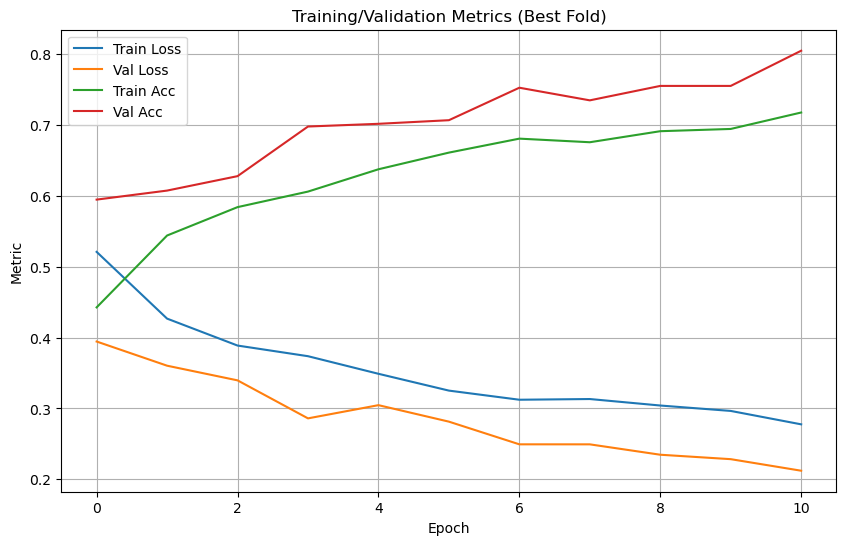

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "", #Include path for the dataset
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "" #Include path for the pre trained weights
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None   # track history for the best fold

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)   # save history for this fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "" #Include save path 
save_path_old = "" #Include save path for old version torch
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold)")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------
Epoch 1: Train Loss 0.1451, Train Acc 0.8705, Val Loss 0.0298, Val Acc 0.9809
Epoch 2: Train Loss 0.0574, Train Acc 0.9475, Val Loss 0.0170, Val Acc 0.9847
Epoch 3: Train Loss 0.0463, Train Acc 0.9558, Val Loss 0.0133, Val Acc 0.9911
Epoch 4: Train Loss 0.0371, Train Acc 0.9644, Val Loss 0.0081, Val Acc 0.9949
Epoch 5: Train Loss 0.0418, Train Acc 0.9593, Val Loss 0.0070, Val Acc 0.9975
Epoch 6: Train Loss 0.0247, Train Acc 0.9749, Val Loss 0.0044, Val Acc 0.9949
Epoch 7: Train Loss 0.0204, Train Acc 0.9809, Val Loss 0.0030, Val Acc 0.9987
Epoch 8: Train Loss 0.0229, Train Acc 0.9790, Val Loss 0.0049, Val Acc 0.9962
Epoch 9: Train Loss 0.0223, Train Acc 0.9758, Val Loss 0.0057, Val Acc 0.9936
Epoch 10: Train Loss 0.0176, Train Acc 0.9812, Val Loss 0.0022, Val Acc 0.9987
Early stopping at epoch 10
Fold 1 Best Val Accuracy: 0.9987

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.1517, Train Acc 0.8479, Val Loss 0.0278, Val Acc 0.9835
Epoch 2: Train Loss

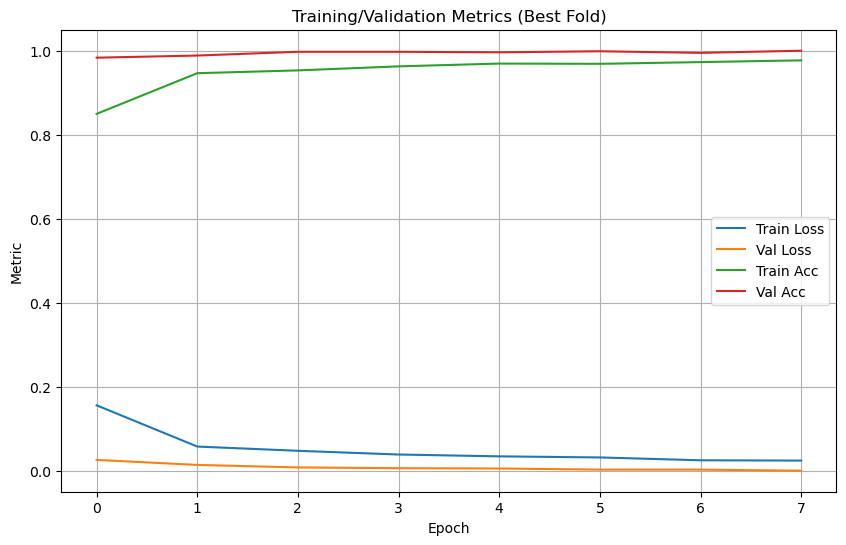

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    " ",  #Include data path 
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = " " #Include checkpoint path 
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None   # track history for the best fold

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)   # save history for this fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "" #Include save path 
save_path_old = "" #Include save old path 
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold)")
plt.legend()
plt.grid(True)
plt.show()
